In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
cmap = sns.light_palette((210, 90, 60), 10, input="husl")
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20

from statsmodels.regression.linear_model import OLS

In [2]:
def VIF(X, idx):
    n_features = X.shape[1]
    x_i = X[:, idx]
    mask = np.arange(n_features) != idx
    X_i = X[:, mask]
    r_squared = OLS(x_i, X_i).fit().rsquared
    vif = 1. / np.maximum(1e-20, (1. - r_squared))
    return vif

In [3]:
class DataGenerator:
    def __init__(self, n_samples=10, n_features=10, n_targets=2, n_irrelevant=3, n_correlated=5):
        self.n_features = n_features
        self.n_samples = n_samples
        self.n_targets = n_targets
        self.n_irrelevant = n_irrelevant
        self.n_correlated = n_correlated
        
    def _get_y(self):
        y = np.random.randn(self.n_samples, self.n_targets)
        return y
    
    def _get_X(self):
        pass
    
    def generate(self):
        pass

In [4]:
dg = DataGenerator()
dg._get_y()

array([[ 2.04159187,  0.18253182],
       [-0.98512396, -0.75964267],
       [ 0.43527478,  1.98275971],
       [ 0.07819095, -1.1157307 ],
       [-0.11033832,  1.91561671],
       [ 0.3344976 ,  2.5913282 ],
       [ 0.60290662, -0.5282144 ],
       [ 0.3838836 ,  0.47333421],
       [ 0.53872776,  0.19437905],
       [ 1.77912485,  0.35339155]])

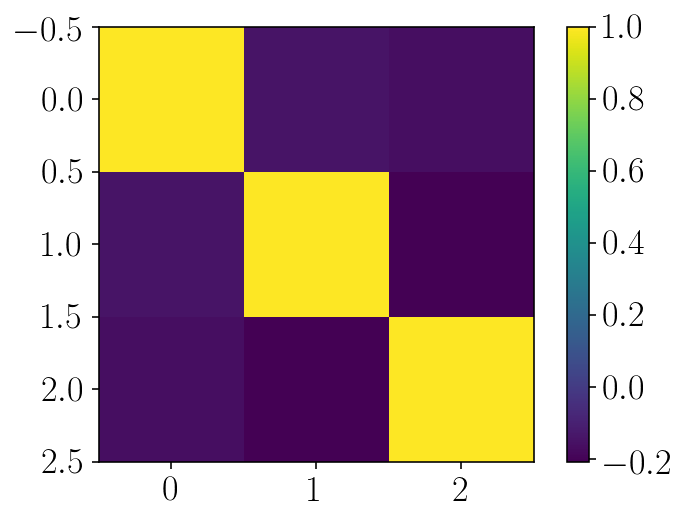

In [5]:
np.random.seed(30)

n_features = 3
n_samples = 100

X = np.random.randn(n_samples, n_features)
X = (X - X.mean(axis=0)) / X.std(axis=0)

plt.imshow(np.corrcoef(X.T))
plt.colorbar()
plt.show()

In [6]:
def generate_collinear_features(n, X):
    n_samples, n_features = X.shape
    X_new = np.zeros([X.shape[0], n])
    for i in range(n):
        n_cols = max(2, np.random.randint(n_features / 3) + 1)
        col_idxs = np.random.choice(np.arange(n_features), int(n_cols), replace=False)
        coef = np.random.rand(n_cols + 1)
        coef /= np.sqrt(np.sum(coef ** 2))
        col = X[:, col_idxs].dot(coef[:-1]) + coef[-1] * np.random.randn(n_samples)
        X_new[:, i] = (col - col.mean()) / col.std()
    return X_new

X_col = generate_collinear_features(20, X)

In [7]:
X = np.hstack([X, X_col])

n_samples, n_features = X.shape

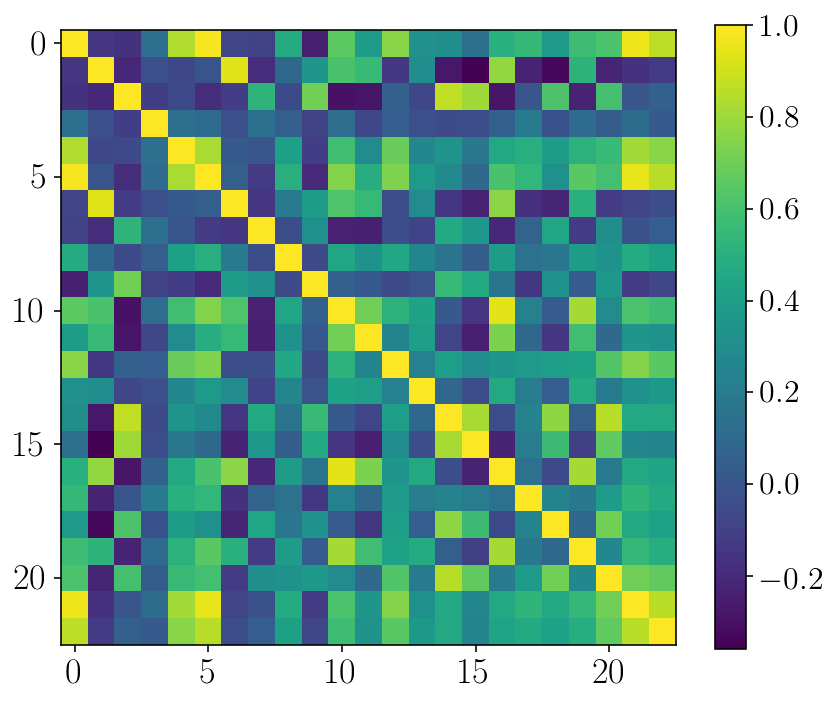

In [8]:
plt.figure(figsize=(6, 5))
plt.imshow(np.corrcoef(X.T))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16) 
plt.tight_layout()
plt.show()

In [9]:
[VIF(X, i) for i in range(X.shape[1])]

[255.66112334971308,
 249.08679643246964,
 71.700870806321319,
 1.3597518713210111,
 4.1129505478168218,
 86.418861207091609,
 10.623147182277696,
 1.7708347905336426,
 1.5843445258825852,
 4.9870247078883887,
 23.172369305166391,
 2.7235152485704925,
 3.4059127327945573,
 1.6710210363595528,
 59.426618034492641,
 5.3576250855346919,
 284.22206794345396,
 1.9021677921349676,
 3.7940375893513374,
 3.9508825017299429,
 9.4258144384862312,
 31.0304691959481,
 6.2409464692971222]

In [10]:
import numpy as np
import sklearn.feature_selection as sklfs
import scipy as sc
import cvxpy as cvx


def corr(X, Y=None, fill=0):
    if Y is None:
        Y = X
    if len(Y.shape) == 1:
        Y = Y[:, np.newaxis]
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    
    X_ = (X - X.mean(axis=0))
    Y_ = (Y - Y.mean(axis=0))
    
    idxs_nz_x = np.where(np.sum(X_ ** 2, axis = 0) != 0)[0]
    idxs_nz_y = np.where(np.sum(Y_ ** 2, axis = 0) != 0)[0]
    
    X_ = X_[:, idxs_nz_x]
    Y_ = Y_[:, idxs_nz_y]
    
    corr = np.ones((X.shape[1], Y.shape[1])) * fill
    
    for i, x in enumerate(X_.T):
        corr[idxs_nz_x[i], idxs_nz_y] = Y_.T.dot(x) / np.sqrt(np.sum(x ** 2) * np.sum(Y_ ** 2, axis=0, keepdims=True))
    return corr


def shift_spectrum(Q):
    lamb_min = sc.linalg.eigh(Q)[0][0]
    if lamb_min < 0:
        Q = Q - lamb_min * np.eye(*Q.shape)
    return Q, lamb_min


class QPFS:
    def __init__(self, sim='corr'):
        if sim not in ['corr', 'info']:
            raise ValueError('Similarity measure should be "corr" or "info"')
        self.sim = sim
    
    def get_Qb(self, X, y, eps=1e-12):
        if self.sim == 'corr':
            self.Q = np.abs(corr(X, fill=1))
            self.b = np.sum(np.abs(corr(X, y)), axis=1)[:, np.newaxis]
        elif self.sim == 'info':
            self.Q = np.ones([X.shape[1], X.shape[1]])
            self.b = np.zeros((X.shape[1], 1))
            for j in range(n_features):
                self.Q[:, j] = sklfs.mutual_info_regression(X, X[:, j])
            if len(y.shape) == 1:
                self.b = sklfs.mutual_info_regression(X, y)[:, np.newaxis]
            else:
                for y_ in y:
                    self.b += sklfs.mutual_info_regression(X, y_)
        self.Q, self.lamb_min = shift_spectrum(self.Q)
    
    def get_alpha(self):
        return self.Q.mean() / (self.Q.mean() + self.b.mean())

    def fit(self, X, y, alpha=None):
        self.get_Qb(X, y)
        self.alpha = alpha if alpha else self.get_alpha()
        self.solve_problem()
    
    def solve_problem(self):
        n = self.Q.shape[0]
        x = cvx.Variable(n)
        c = np.ones((n, 1))
        objective = cvx.Minimize((1 - self.alpha) * cvx.quad_form(x, self.Q) - 
                                 self.alpha * self.b.T * x)
        constraints = [x >= 0, c.T * x == 1]
        prob = cvx.Problem(objective, constraints)

        prob.solve()

        self.status = prob.status
        self.score = np.array(x.value).flatten()
        
    def __repr__(self):
        return f'QPFS(sim="{self.sim}")'


class MultivariateQPFS:
    def __init__(self):
        pass
    
    def get_params(self, X, Y, eps=1e-12):
        self.Q_x = np.abs(corr(X, fill=1))
        self.Q_y = np.abs(corr(Y, fill=1))
        self.B = np.abs(corr(X, Y))

    def fit(self, X, Y):
        self.get_params(X, Y)
        alpha = np.mean(self.Q_x) / (np.mean(self.Q_x) + np.mean(self.B))
        self.solve_problem([1 - alpha, alpha, 0.])
    
    def solve_problem(self, alphas):
        n = self.Q_x.shape[0]
        r = self.Q_y.shape[0]
        
        Q = np.vstack((np.hstack((alphas[0] * self.Q_x, -alphas[1] / 2 * self.B)),
                       np.hstack(( -alphas[1] / 2 * self.B.T, alphas[2] * self.Q_y))))
        Q, lamb_min = shift_spectrum(Q)
        print(lamb_min)
        
        a = cvx.Variable(n + r)
        
        c = np.zeros((2, n + r))
        c[0, :n] = 1
        c[1, n:] = 1
        
        objective = cvx.Minimize(cvx.quad_form(a, Q))
        constraints = [a >= 0, c * a == 1]
        prob = cvx.Problem(objective, constraints)

        prob.solve()

        self.status = prob.status
        self.score = np.array(a.value).flatten()
        
    def __repr__(self):
        return f'QPFS(sim="{self.sim}")'

In [11]:
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
Y = np.repeat(y[:, np.newaxis], repeats=10, axis=1)
X = np.hstack([X, np.zeros((X.shape[0], 1))])

In [12]:
qpfs = QPFS()
qpfs.fit(X, y)
print(*['{:.4f}'.format(x) for x in qpfs.score], sep='\t')

0.0722	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000


In [13]:
qpfs = QPFS()
qpfs.fit(X, Y)
print(*['{:.4f}'.format(x) for x in qpfs.score], sep='\t')

0.0721	0.0607	0.0455	0.1049	0.0425	0.1967	0.0371	0.0000	0.0247	0.0492	0.1248	0.0866	0.1551	0.0000


In [14]:
qpfs2 = MultivariateQPFS()

qpfs2.get_params(X, y)

alpha = np.mean(qpfs2.Q_x) / (np.mean(qpfs2.Q_x) + np.mean(qpfs2.B))
qpfs2.solve_problem([1 - alpha, alpha, 0.])
print(*['{:.4f}'.format(x) for x in qpfs2.score], sep='\t')

-0.587839000174
0.0757	0.0677	0.0469	0.1153	0.0453	0.1787	0.0446	0.0000	0.0329	0.0494	0.1188	0.0908	0.1340	0.0000	1.0000


In [15]:
qpfs2 = MultivariateQPFS()

qpfs2.get_params(X, Y)

alpha = np.mean(qpfs2.Q_x) / (np.mean(qpfs2.Q_x) + np.mean(qpfs2.B))
qpfs2.solve_problem([1 - alpha, alpha, 0.])
print(*['{:.4f}'.format(x) for x in qpfs2.score], sep='\t')

-1.12750362869
0.0761	0.0704	0.0567	0.1058	0.0532	0.1466	0.0542	0.0251	0.0485	0.0576	0.1066	0.0858	0.1135	0.0000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000	0.1000


In [44]:
Q = np.array([[1., 0., .0],
               [0., 1., 0.8],
               [.0, 0.8, 1.]])
print(Q)
r = 5
B = np.hstack((np.repeat(np.array([[0.4], [0.5], [0.8]]), repeats=r - 1, axis=1), np.array([[0.], [.8], [.1]])))
print(B[:, :17])
b = np.mean(B, axis=1, keepdims=True)
print(b)

[[ 1.   0.   0. ]
 [ 0.   1.   0.8]
 [ 0.   0.8  1. ]]
[[ 0.4  0.4  0.4  0.4  0. ]
 [ 0.5  0.5  0.5  0.5  0.8]
 [ 0.8  0.8  0.8  0.8  0.1]]
[[ 0.32]
 [ 0.56]
 [ 0.66]]


In [45]:
Q = shift_spectrum(Q)[0]
qpfs.Q, qpfs.b = Q, b
qpfs.get_alpha()
qpfs.solve_problem()
print(*['{:.4f}'.format(x) for x in qpfs.score], sep='\t')

0.4623	0.2502	0.2876
